In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation, Embedding
from keras.utils import np_utils

In [2]:
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'D:/HAR/UCI-HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'D:/HAR/UCI-HAR/')
    
    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Standing:" ,np.where(trainy == 4)[0].size)
print("6: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Standing: 1374
6: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)  

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)   

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

In [10]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

In [11]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size) 

0: Walking: 0
1: WU: 0
2: WD: 0
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [12]:
trainy = trainy - 3
testy = testy - 3

In [13]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [14]:
trainy_one_hot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [15]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [16]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)  

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)  

Train data label statistics::
[[   0 1286]
 [   1 1374]
 [   2 1407]]
Test data label statistics::
[[  0 491]
 [  1 532]
 [  2 537]]


In [17]:
trainX.shape, testX.shape, testX.shape, trainy.shape, testy.shape, trainy_one_hot.shape, testy_one_hot.shape, 

((4067, 128, 9),
 (1560, 128, 9),
 (1560, 128, 9),
 (4067, 1),
 (1560, 1),
 (4067, 3),
 (1560, 3))

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [21]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

In [22]:
trainy_one_hot.shape

(4067, 3)

In [23]:
n_timesteps, n_features, n_outputs 

(128, 9, 3)

In [24]:
import numpy as np
def PReLU(z,α) :
  fn =np.max(αz,z)
  return(fn)

In [29]:
!pip install keras_self_attention 

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18911 sha256=5b7e08e2b97e6a3186cf0f04382c20bf03fb55f6af3d43ea930fc037f2f82d9b
  Stored in directory: c:\users\gc\appdata\local\pip\cache\wheels\ac\13\2d\3de7c76f618a8d162884ac5b726a8c2242ad88afa370f1e62f
Successfully built keras-self-attention


In [30]:
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention

In [26]:
import tensorflow as tf

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.max_pool = tf.keras.layers.GlobalMaxPooling1D()
        self.fc1 = tf.keras.layers.Dense(reduction_ratio)
        self.relu1 = tf.keras.layers.ReLU()
        self.fc2 = tf.keras.layers.Dense(1)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')
        
    def call(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x)))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x)))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = tf.keras.layers.Conv1D(1, kernel_size, padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')
        
    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=2, keepdims=True)
        max_out = tf.reduce_max(x, axis=2, keepdims=True)
        combined_out = tf.concat([avg_out, max_out], axis=2)
        out = self.conv(combined_out)
        return self.sigmoid(out)

class CBAM1D(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, spatial_kernel_size=7):
        super(CBAM1D, self).__init__()
        self.channel_attention = ChannelAttention(reduction_ratio)
        self.spatial_attention = SpatialAttention(spatial_kernel_size)
        
    def call(self, x):
        x_channel = x * self.channel_attention(x)
        x_spatial = x * self.spatial_attention(x)
        return x_channel + x_spatial                         

SyntaxError: invalid syntax (<ipython-input-26-b4a3d67790b9>, line 15)

In [50]:
sequence_length = 10
input_dim = n_timesteps # 입력 차원
hidden_dim = 64  # 은닉 차원
num_classes = 2

# SeqSelfAttention을 포함한 간단한 모델 정의
model = tf.keras.Sequential([    
    SeqSelfAttention(attention_activation='sigmoid'),  # attention_type은 'attention'으로 고정
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(n_outputs, activation='softmax')
])

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
validation_split = 0.1
batch_size = 128

In [54]:
train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/10
29/29 [==============================] - 20s 650ms/step - loss: 1.3148 - accuracy: 0.2434 - val_loss: 0.9609 - val_accuracy: 0.8870
Epoch 2/10
29/29 [==============================] - 19s 641ms/step - loss: 1.2746 - accuracy: 0.2451 - val_loss: 0.9620 - val_accuracy: 0.8919
Epoch 3/10
29/29 [==============================] - 19s 660ms/step - loss: 1.2372 - accuracy: 0.2489 - val_loss: 0.9604 - val_accuracy: 0.8943
Epoch 4/10
29/29 [==============================] - 19s 660ms/step - loss: 1.2023 - accuracy: 0.2571 - val_loss: 0.9597 - val_accuracy: 0.8943
Epoch 5/10
29/29 [==============================] - 18s 625ms/step - loss: 1.1699 - accuracy: 0.2686 - val_loss: 0.9542 - val_accuracy: 0.8943
Epoch 6/10
29/29 [==============================] - 18s 626ms/step - loss: 1.1394 - accuracy: 0.2902 - val_loss: 0.9463 - val_accuracy: 0.8894
Epoch 7/10
29/29 [==============================] - 18s 625ms/step - loss: 1.1108 - accuracy: 0.3361 - val_loss: 0.9399 - val_accuracy: 0.8894

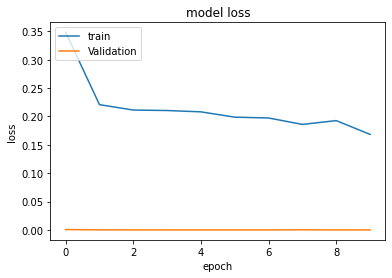

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

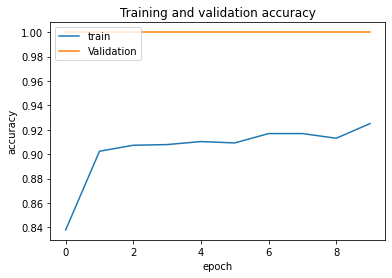

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
[[383 108   0]
 [ 58 474   0]
 [  0   0 537]]
0.8935897435897436
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       491
           1       0.81      0.89      0.85       532
           2       1.00      1.00      1.00       537

    accuracy                           0.89      1560
   macro avg       0.89      0.89      0.89      1560
weighted avg       0.90      0.89      0.89      1560



<Axes: >

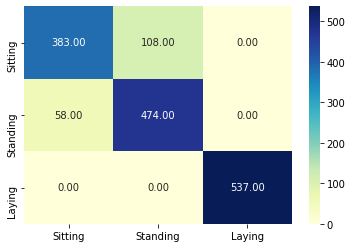

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)

LABELS = ['Sitting', 'Standing', 'Laying']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')